In [39]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon

from Functions import prep_training_test_data, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data

In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


Create naive dataset

In [3]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

# Polygons for mapping onto graphs

In [4]:
## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_2500/4200828156.py:4: DtypeWarning: Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')


# Percent exceeding capacity 

In [5]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Global values

In [6]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_exact = 'exact'  # Choose 'period', 'exact', or 'exact'
size_of_test_dataset = 4
train_weeks_for_initial_model = 4

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 100  
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Naive classifier

In [7]:
weeks_to_predict = range(1,123 - size_of_test_dataset - train_weeks_for_initial_model - 1 - 1, 4)

In [24]:


ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

  
        # exact
    X_train_naive_exact, y_train_naive_exact, weights_naive_exact, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography=geography_column, weight_col='weight', keep_output=True)

    X_test_naive_exact, y_test_naive_exact, weights_test_naive_exact, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography=geography_column, weight_col='weight', keep_output=True)
    weights_naive_exact = weights_naive_exact[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_exact, y_train_naive_exact, sample_weight=weights_naive_exact)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_exact)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_exact)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive_exact, y_pred))
    ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive_exact, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive_exact, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive_exact, y_pred) + 1)/2)

1
range(1, 6)
range(6, 10)
5
range(1, 10)
range(10, 14)
9
range(1, 14)
range(14, 18)
13
range(1, 18)
range(18, 22)
17
range(1, 22)
range(22, 26)
21
range(1, 26)
range(26, 30)
25
range(1, 30)
range(30, 34)
29
range(1, 34)
range(34, 38)
33
range(1, 38)
range(38, 42)
37
range(1, 42)
range(42, 46)
41
range(1, 46)
range(46, 50)
45
range(1, 50)
range(50, 54)
49
range(1, 54)
range(54, 58)
53
range(1, 58)
range(58, 62)
57
range(1, 62)
range(62, 66)
61
range(1, 66)
range(66, 70)
65
range(1, 70)
range(70, 74)
69
range(1, 74)
range(74, 78)
73
range(1, 78)
range(78, 82)
77
range(1, 82)
range(82, 86)
81
range(1, 86)
range(86, 90)
85
range(1, 90)
range(90, 94)
89
range(1, 94)
range(94, 98)
93
range(1, 98)
range(98, 102)
97
range(1, 102)
range(102, 106)
101
range(1, 106)
range(106, 110)
105
range(1, 110)
range(110, 114)
109
range(1, 114)
range(114, 118)


# Metrics from loaded models

In [17]:

# Initialize lists to store results


ROC_by_week_full_exact = []
accuracy_by_week_full_exact = []
norm_MCC_by_week_full_exact = []

size_of_test_dataset = 4

for prediction_week in weeks_to_predict:
    # Evaluate the period model
    model_name = "/Users/rem76/Documents/COVID_projections/Exact_analysis/Expanding_models_four_week_delivery/Full_model"
    accuracy_exact, roc_auc_exact, mcc_exact = prepare_data_and_model(HSA_weekly_data_all, weeks_in_future, geography_column, weight_col, keep_output,'exact', model_name, prediction_week, size_of_test_dataset, train_weeks_for_initial_model)
    accuracy_by_week_full_exact.append(accuracy_exact)
    ROC_by_week_full_exact.append(roc_auc_exact)
    norm_MCC_by_week_full_exact.append(mcc_exact)



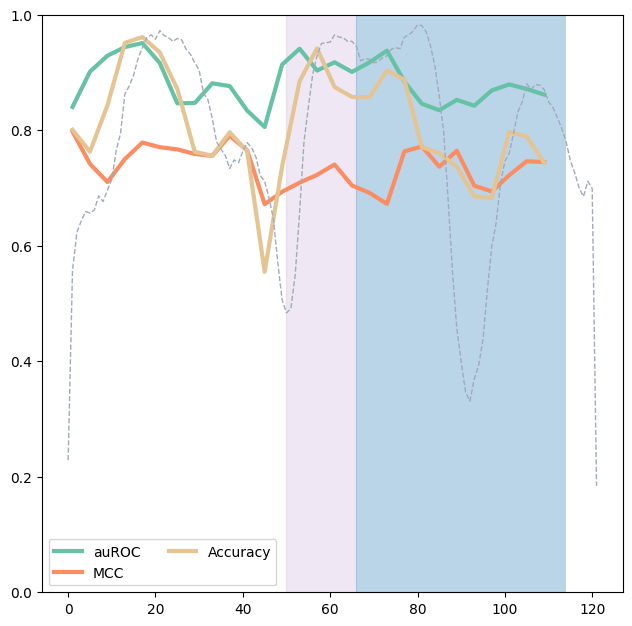

In [18]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5), sharey = 'all')

# Plot data on the same plot
axs.plot(weeks_to_predict, ROC_by_week_full_exact, label='auROC', linewidth=3, color=palette[0])
axs.plot(weeks_to_predict, norm_MCC_by_week_full_exact, label='MCC', linewidth=3, color=palette[1])
axs.plot(weeks_to_predict, accuracy_by_week_full_exact, label='Accuracy', linewidth=3, color=palette[5])
axs.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')
axs.set_ylim(0,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs.legend(ncol = 2, loc='lower left')

polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
axs.add_patch(polygon_delta)
polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
axs.add_patch(polygon_omricon)
plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_full_expanding_train_models_exact_4_week_delivery_test_{size_of_test_dataset}_week.png', dpi = 300)

# Combined graph

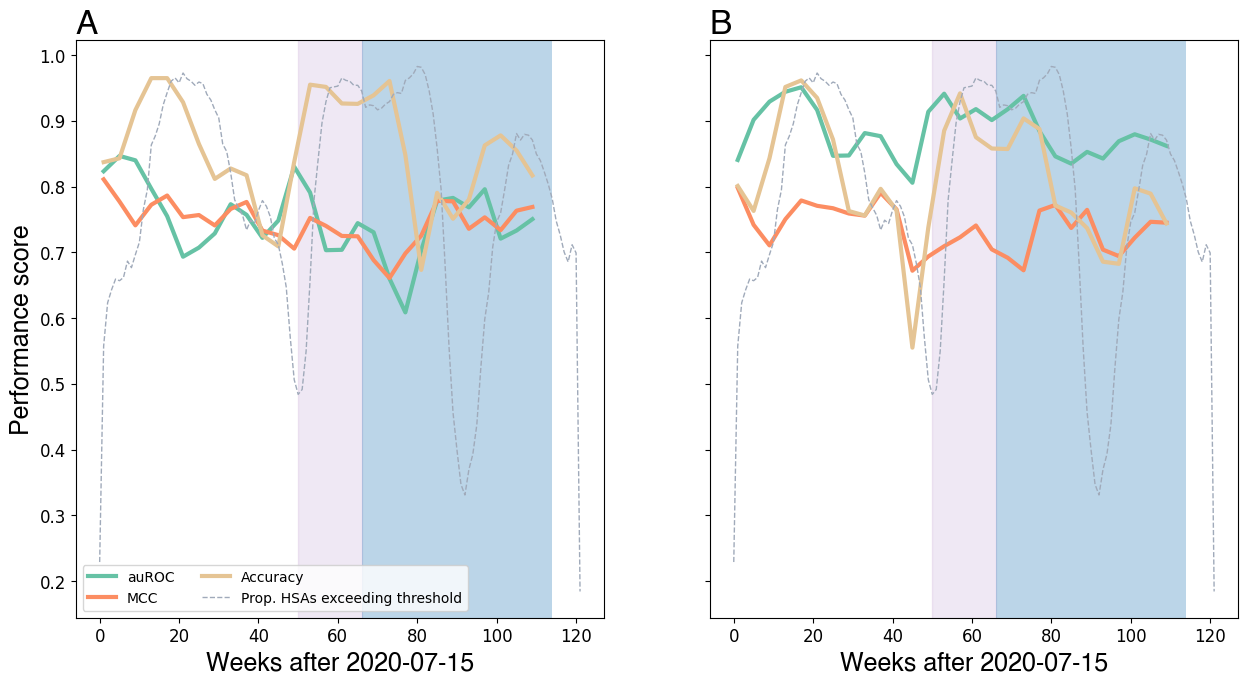

In [25]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), sharey = 'all')
axs = axs.ravel()
# Plot data on the same plot
axs[0].plot(weeks_to_predict, ROC_by_week_naive_exact, label='auROC', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict, norm_MCC_by_week_naive_exact, label='MCC', linewidth = 3, color = palette[1])
axs[0].plot(weeks_to_predict, accuracy_by_week_naive_exact, label='Accuracy', linewidth = 3, color = palette[5])
axs[0].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs exceeding threshold')
axs[1].plot(weeks_to_predict, ROC_by_week_full_exact, label='auROC', linewidth=3, color=palette[0])
axs[1].plot(weeks_to_predict, norm_MCC_by_week_full_exact, label='MCC', linewidth=3, color=palette[1])
axs[1].plot(weeks_to_predict, accuracy_by_week_full_exact, label='Accuracy', linewidth=3, color=palette[5])
axs[1].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')



# Add labels and legend
axs[0].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
axs[1].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=12)

add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[0].legend(ncol = 2, loc='lower left')

for ax in axs:
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_full_and_naive_expanding_train_models_test_{size_of_test_dataset}_week_four_week_delivery.png', dpi = 300)

# Combined graph - by metric 

In [27]:
weeks_to_predict_every_four_weeks_graph = range(5,  max(weeks_to_predict) + 5,4)


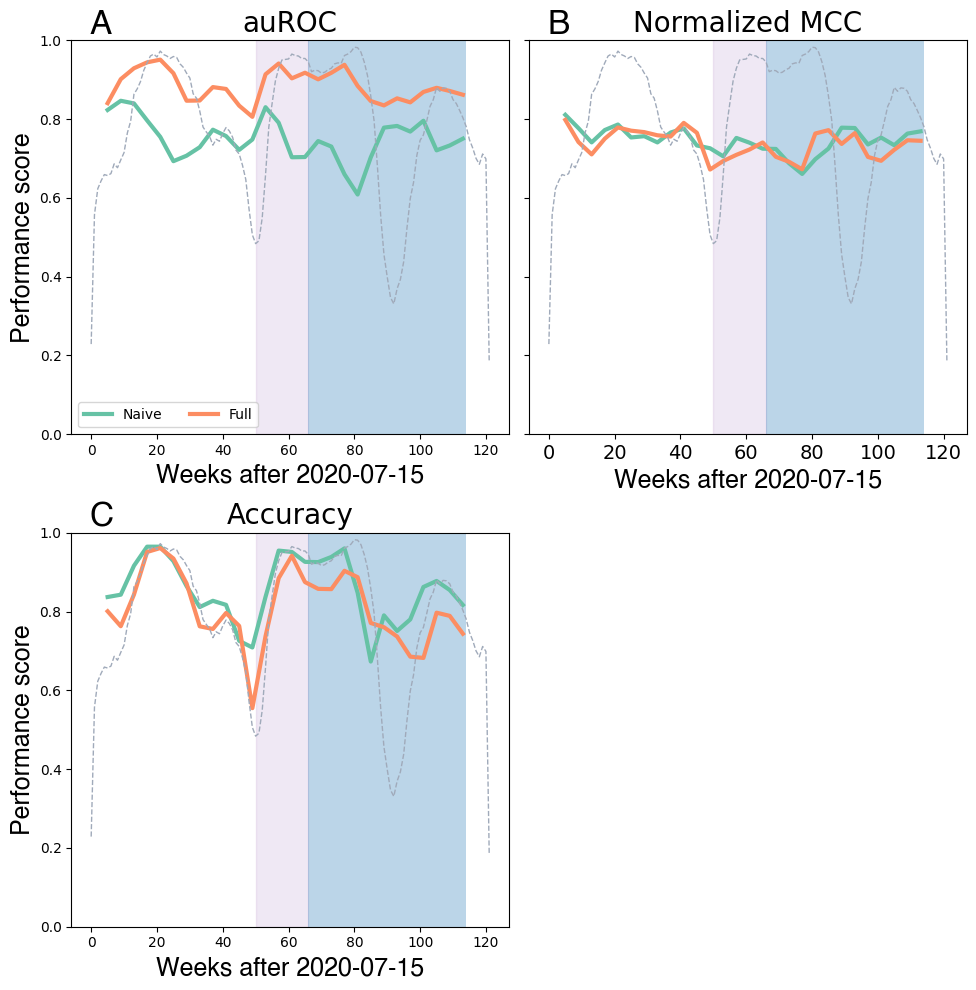

In [52]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey = 'all')
axs = axs.ravel()
fig.delaxes(axs[3])
# Plot data on the same plot
axs[0].plot(weeks_to_predict_every_four_weeks_graph, ROC_by_week_naive_exact, label='Naive', linewidth = 3, color = palette[0])
axs[0].plot(weeks_to_predict_every_four_weeks_graph, ROC_by_week_full_exact, label='Full', linewidth=3, color=palette[1])

axs[1].plot(weeks_to_predict_every_four_weeks_graph, norm_MCC_by_week_naive_exact, label='Naive', linewidth = 3, color = palette[0])
axs[1].plot(weeks_to_predict_every_four_weeks_graph, norm_MCC_by_week_full_exact, label='Full', linewidth=3, color=palette[1])

axs[2].plot(weeks_to_predict_every_four_weeks_graph, accuracy_by_week_naive_exact, label='Naive', linewidth = 3, color = palette[0])
axs[2].plot(weeks_to_predict_every_four_weeks_graph, accuracy_by_week_full_exact, label='Dull', linewidth=3, color=palette[1])

axs[0].set_title("auROC",fontsize=20)
axs[1].set_title("Normalized MCC",fontsize=20)
axs[2].set_title("Accuracy",fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=14)

add_labels_to_subplots(axs, hfont, 1.03, 24)

for ax in axs:
    ax.set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )

    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    ax.add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                      alpha=0.3)
    ax.add_patch(polygon_omricon)
    ax.plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth=1, color='#A0AABA', linestyle='--')


axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[2].set_ylabel('Performance score',**hfont,  fontsize = 18)

axs[0].set_ylim(0,1)

axs[0].legend(ncol = 2, loc='lower left')
plt.tight_layout()

plt.savefig(f'/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Performance_full_and_naive_expanding_train_models_test_{size_of_test_dataset}_week_four_week_delivery_by_metric.png', dpi = 300,bbox_inches='tight')